In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm
from tqdm import tqdm

from plato.planets.populations import PopulationModel
from plato.planets.observation import ObservationModel
from plato.stars import filter_valid_targets
from plato.visualisation import FigureProcessor, get_palette, set_plot_defaults
from plato.utils import get_abspath

In [3]:
set_plot_defaults()

figure_directory = f"/figures/08_heatmaps/"
save = True

In [4]:
LOPS2 = pd.read_csv(get_abspath() + f"data/processed/LOPS2_targets.csv")
LOPN1 = pd.read_csv(get_abspath() + f"data/processed/LOPN1_targets.csv")

unfiltered_fields = pd.concat([LOPS2, LOPN1])
fields = filter_valid_targets(unfiltered_fields)
fields = fields[
    [
        "Radius",
        "Mass",
        "[Fe/H]",
        "u1",
        "u2",
        "gaiaV",
        "n_cameras",
        "Population",
    ]
]

fields["cos_i"] = 0
fields["sigma_star"] = 10e-6
fields = fields.rename(
    columns={
        "Radius": "R_star",
        "Mass": "M_star",
        "gaiaV": "Magnitude_V",
    }
)

## CREATE MOCK OBSERVATIONS

In [5]:
# num_mocks = 300
# obs_model = ObservationModel(load_mocks=False)

# obs_model.save_mocks(
#     fields,
#     num_embryos=[10, 20, 50, 100],
#     num_mocks=num_mocks,
# )
# obs_model.save_mocks(
#     fields,
#     num_embryos=[10, 20, 50, 100],
#     metallicity_limit=-0.6,
#     num_mocks=num_mocks,
# )

In [6]:
obs_model = ObservationModel(num_mocks=100)
period_bins = [0.5, 1, 2, 5, 10, 20, 50, 100, 250, 500, 750]

## PLOT HEATMAPS

In [7]:
pops = {}
for pop in [
    "Thin Disk",
    "Thick Disk",
    "Halo",
    "Thin Disk (Metallicity Cut)",
    "Thick Disk (Metallicity Cut)",
    "Halo (Metallicity Cut)",
]:
    data = obs_model.stats_pivot_table(
        num_embryos=[10, 50, 100],
        statistic="mean",
        population=pop.replace(" (Metallicity Cut)", ""),
        select_metallicity_cut_mocks=True if "(Metallicity Cut)" in pop else False,
    )
    data_annots = obs_model.formatted_statistics(
        num_embryos=[10, 50, 100],
        population=pop.replace(" (Metallicity Cut)", ""),
        select_metallicity_cut_mocks=True if "(Metallicity Cut)" in pop else False,
    )
    pops[pop] = (data, data_annots)

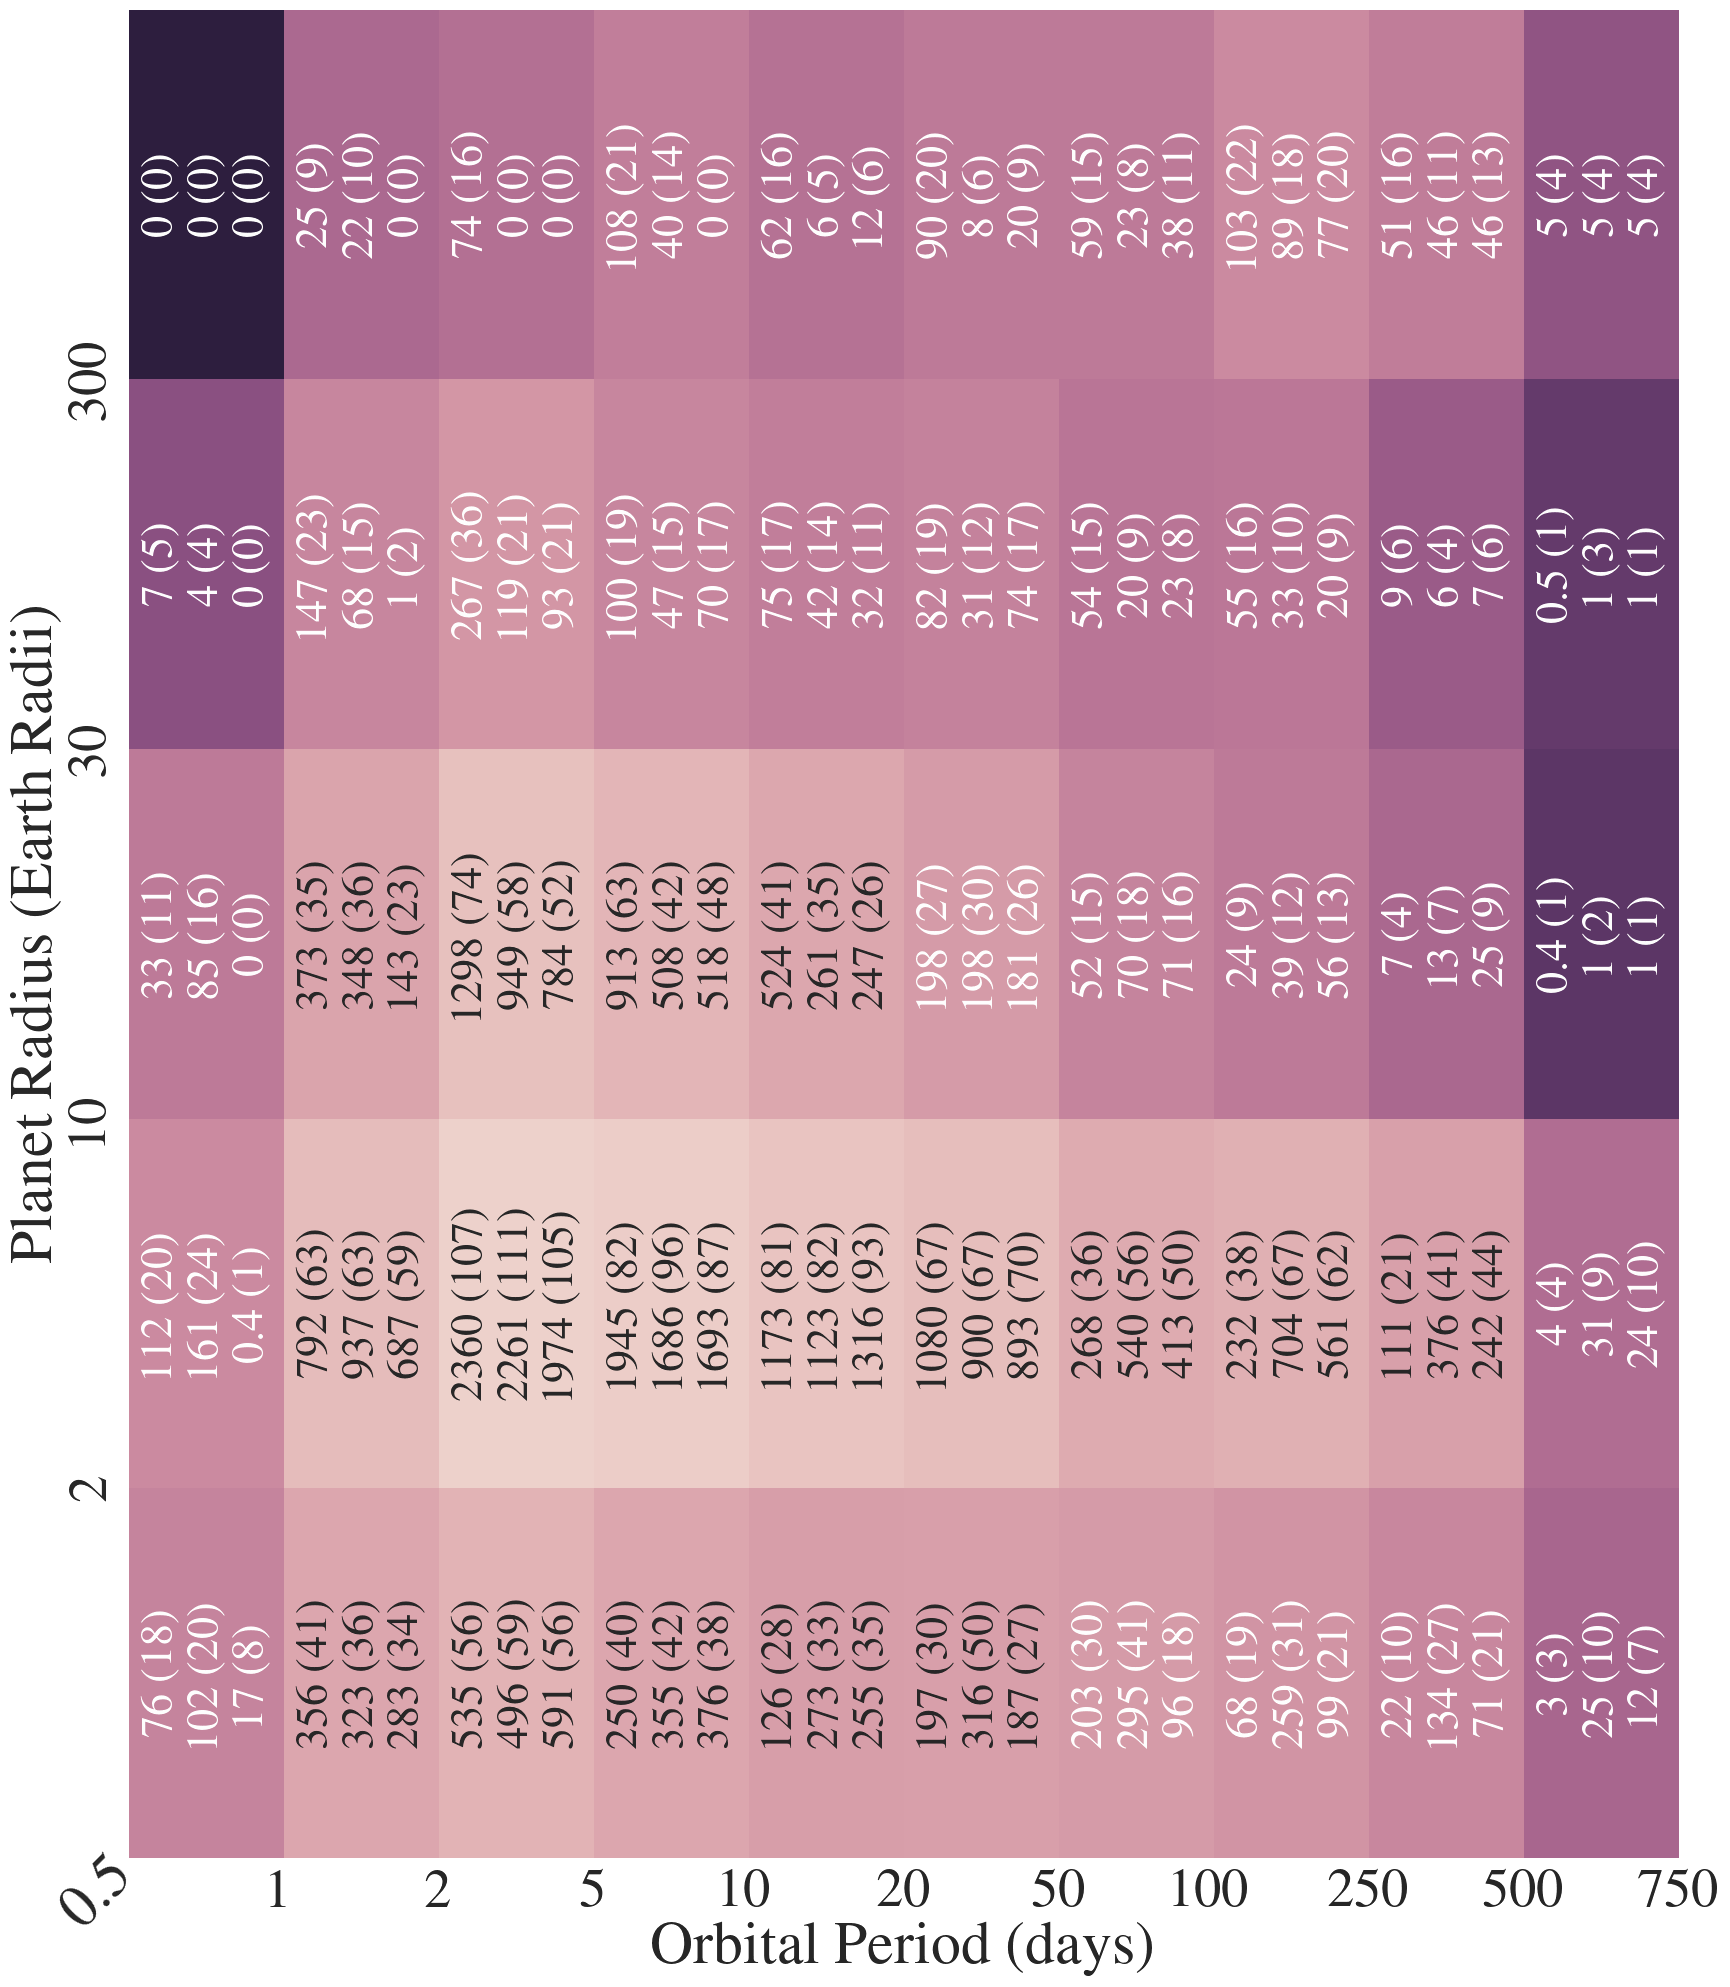

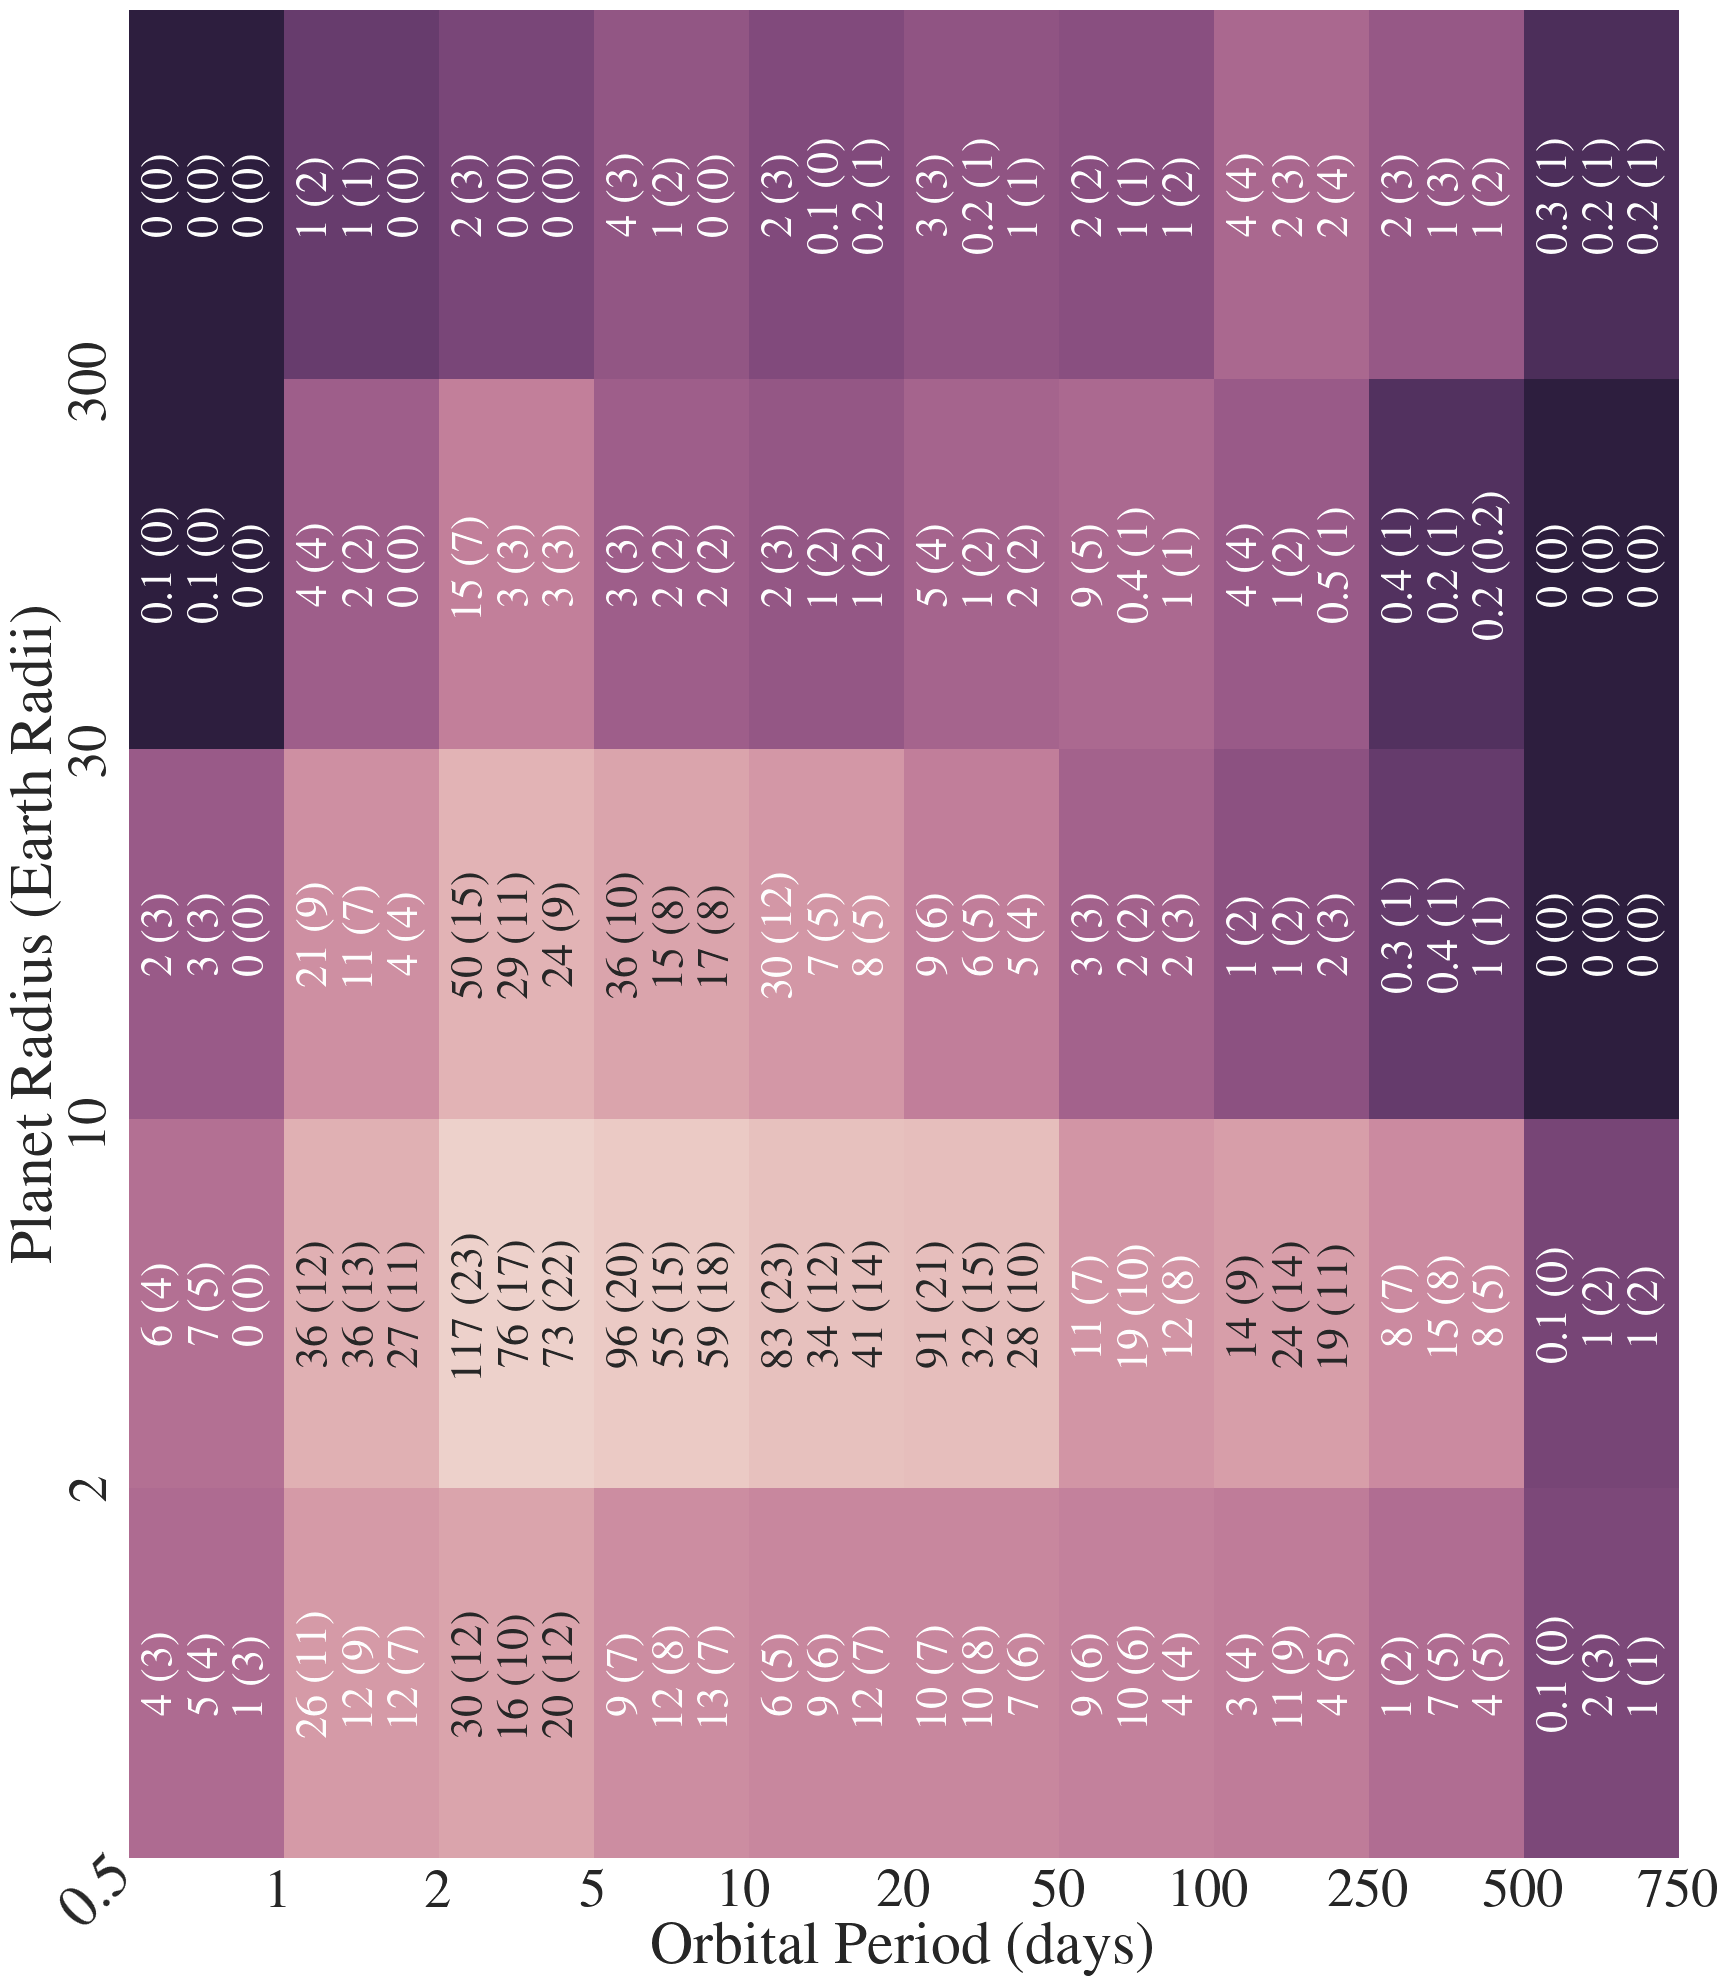

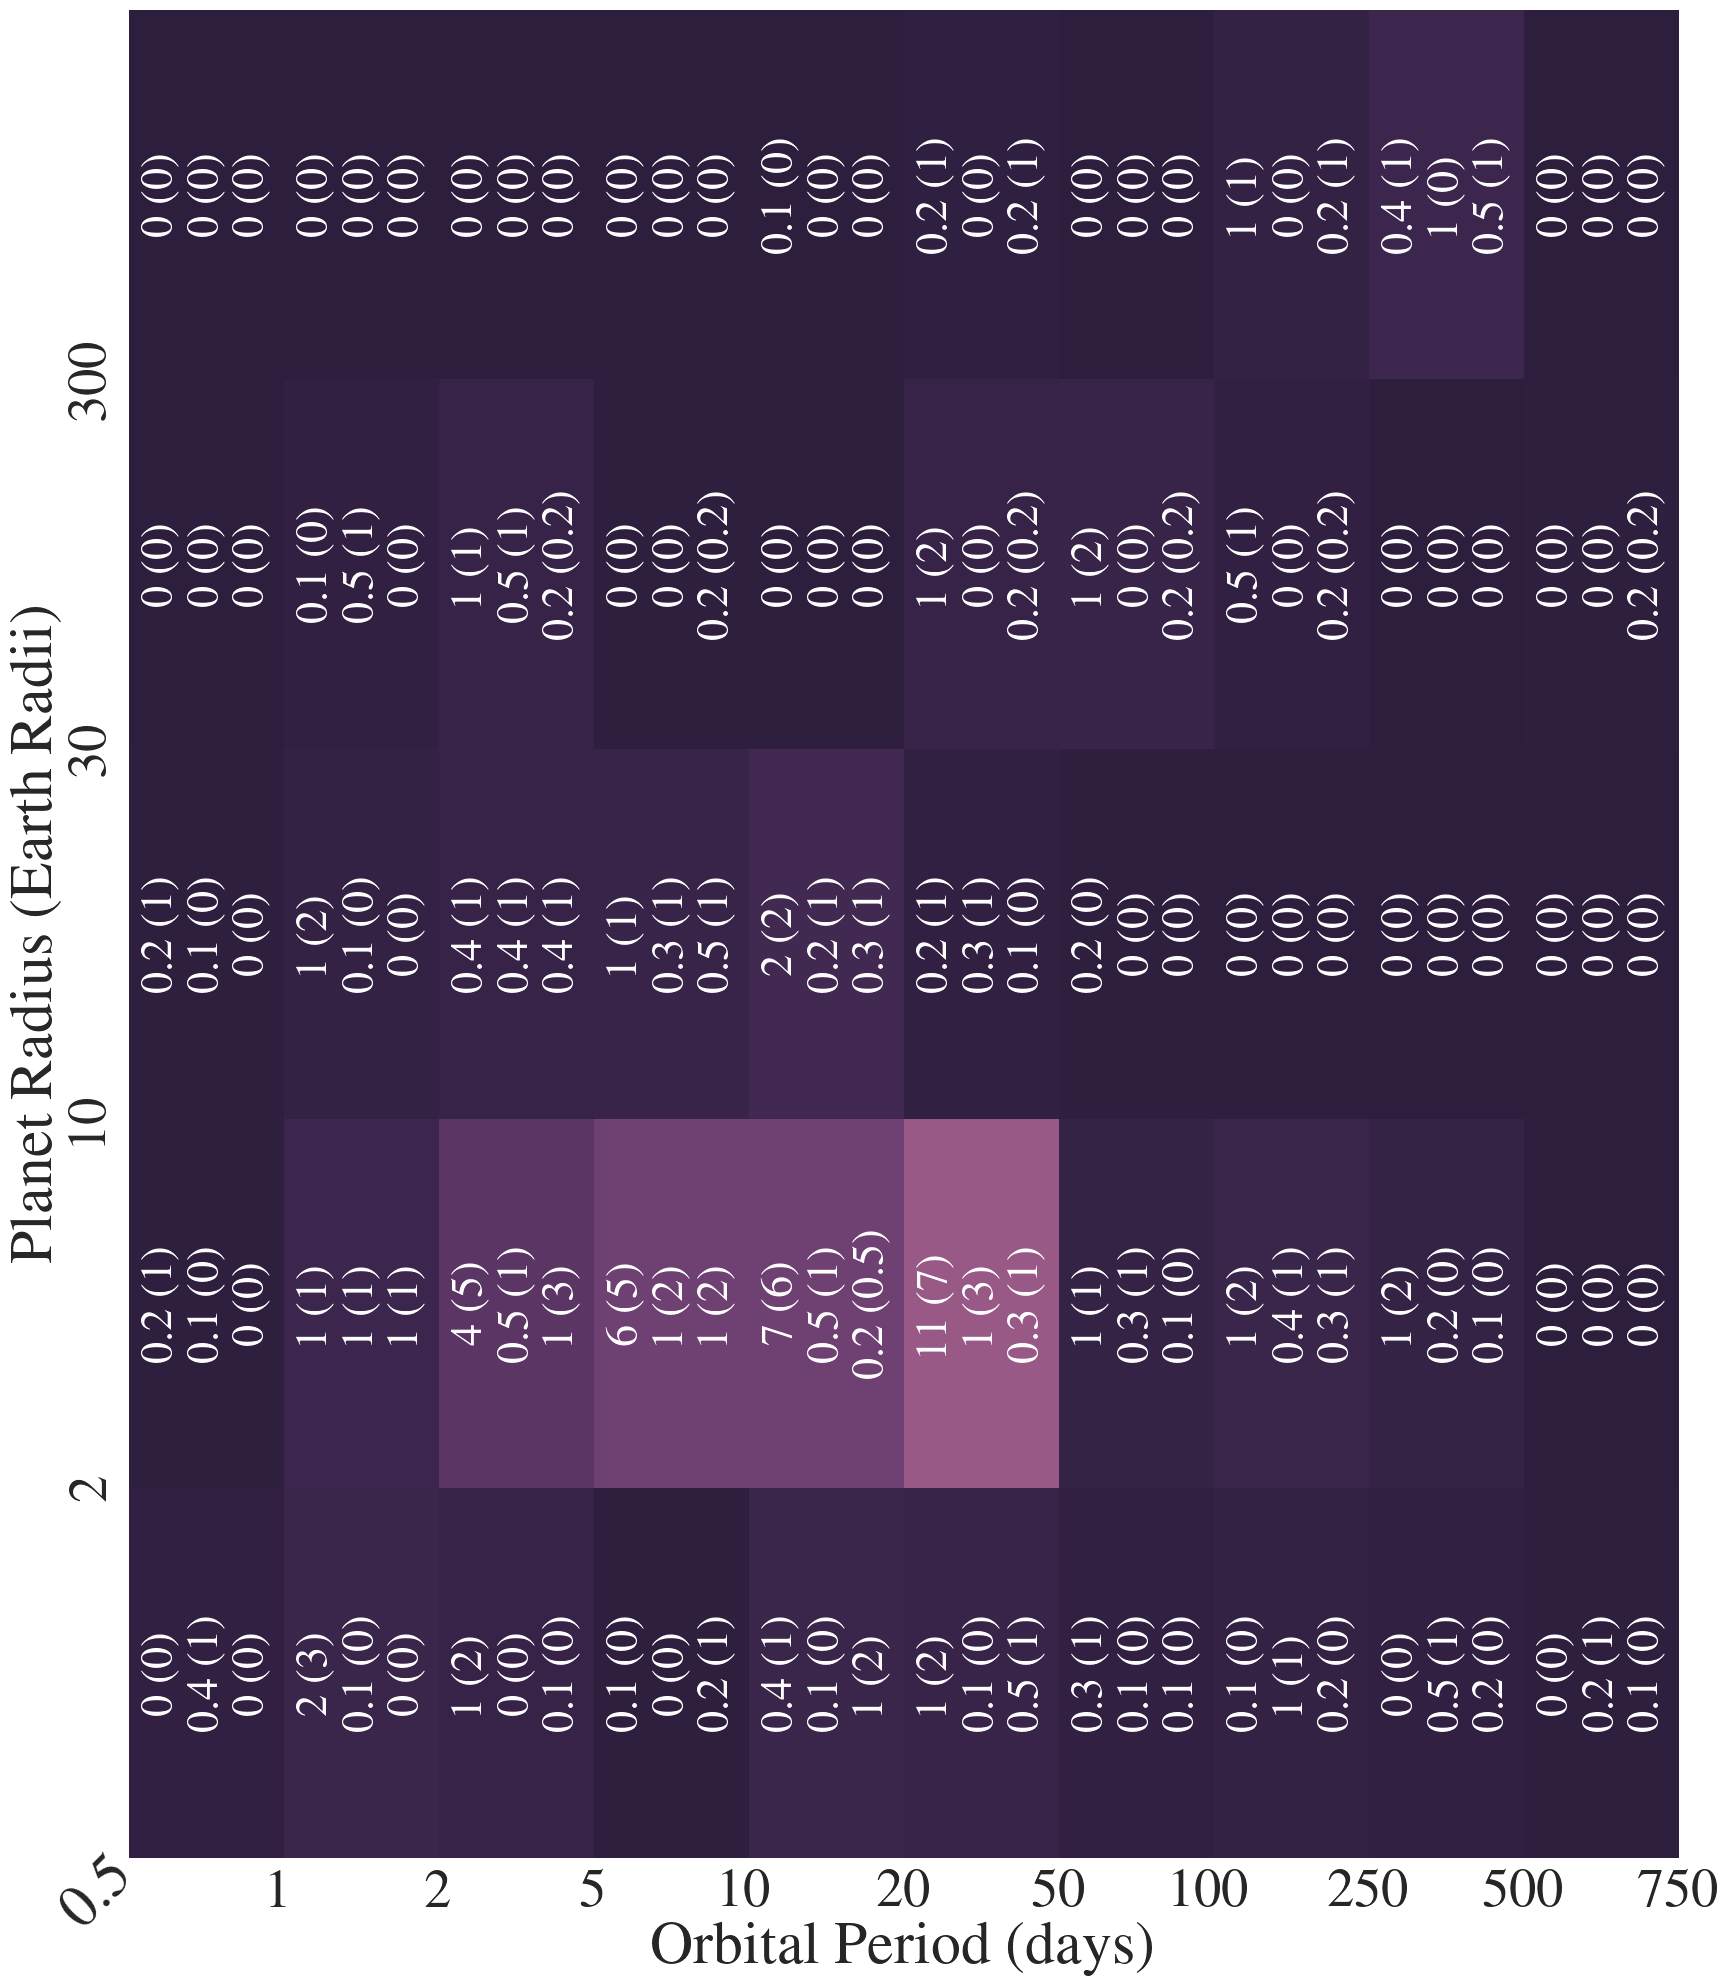

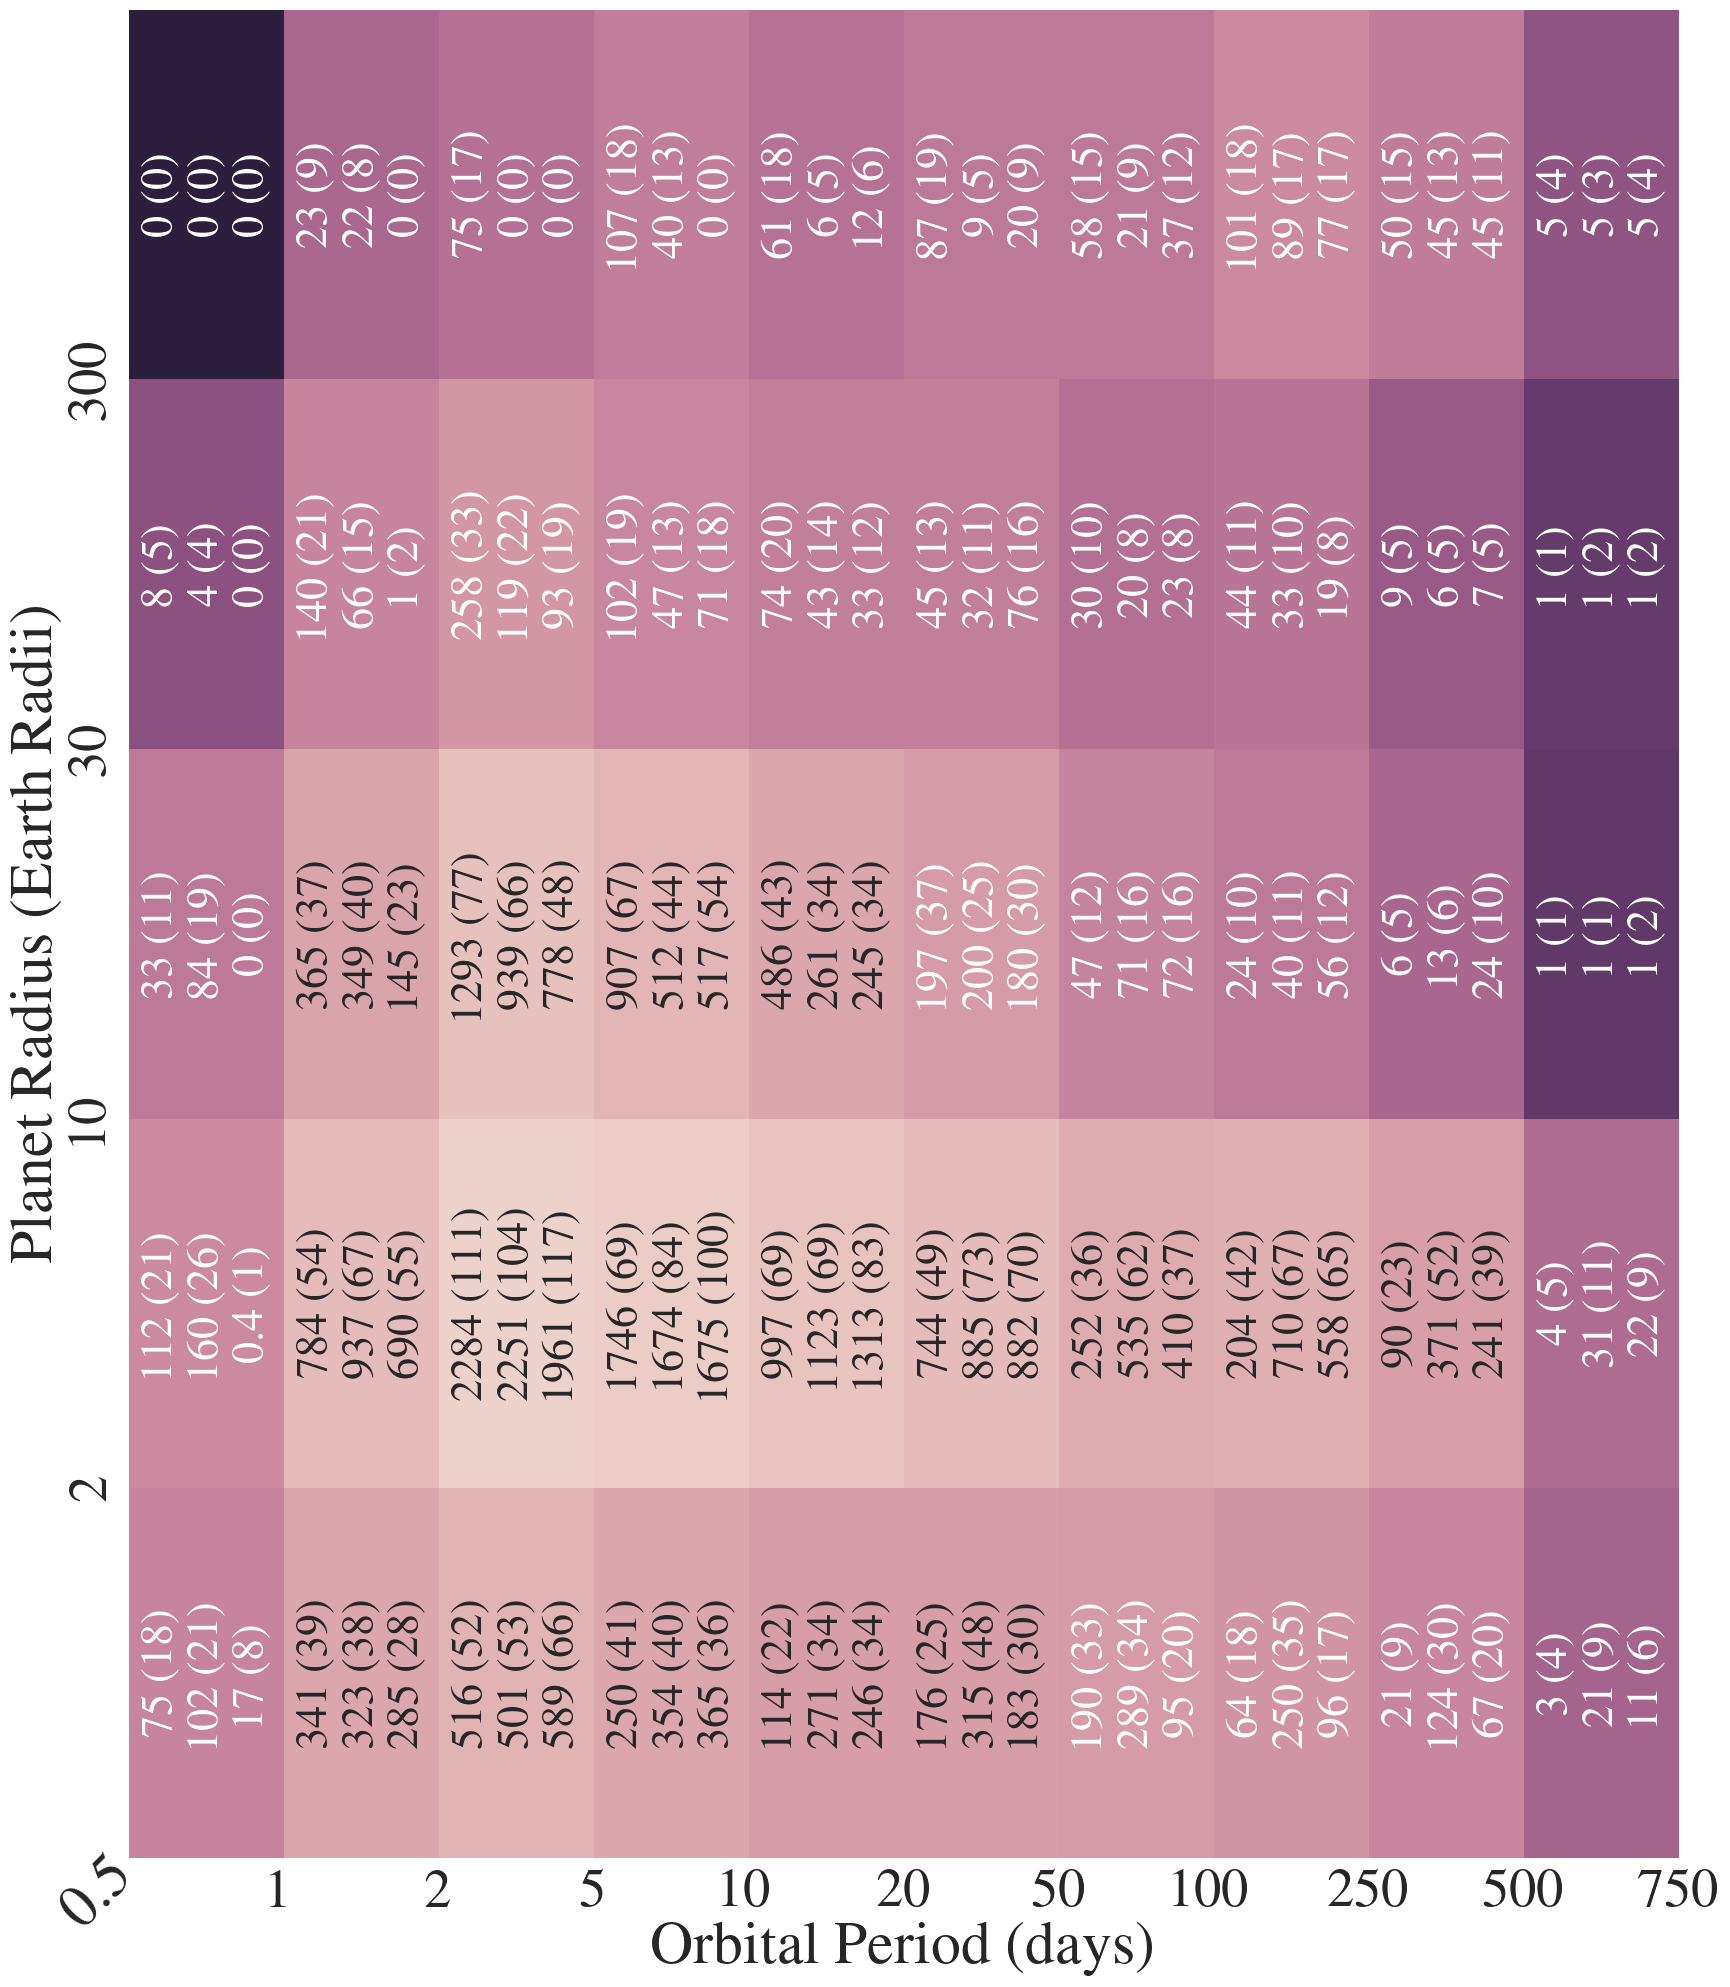

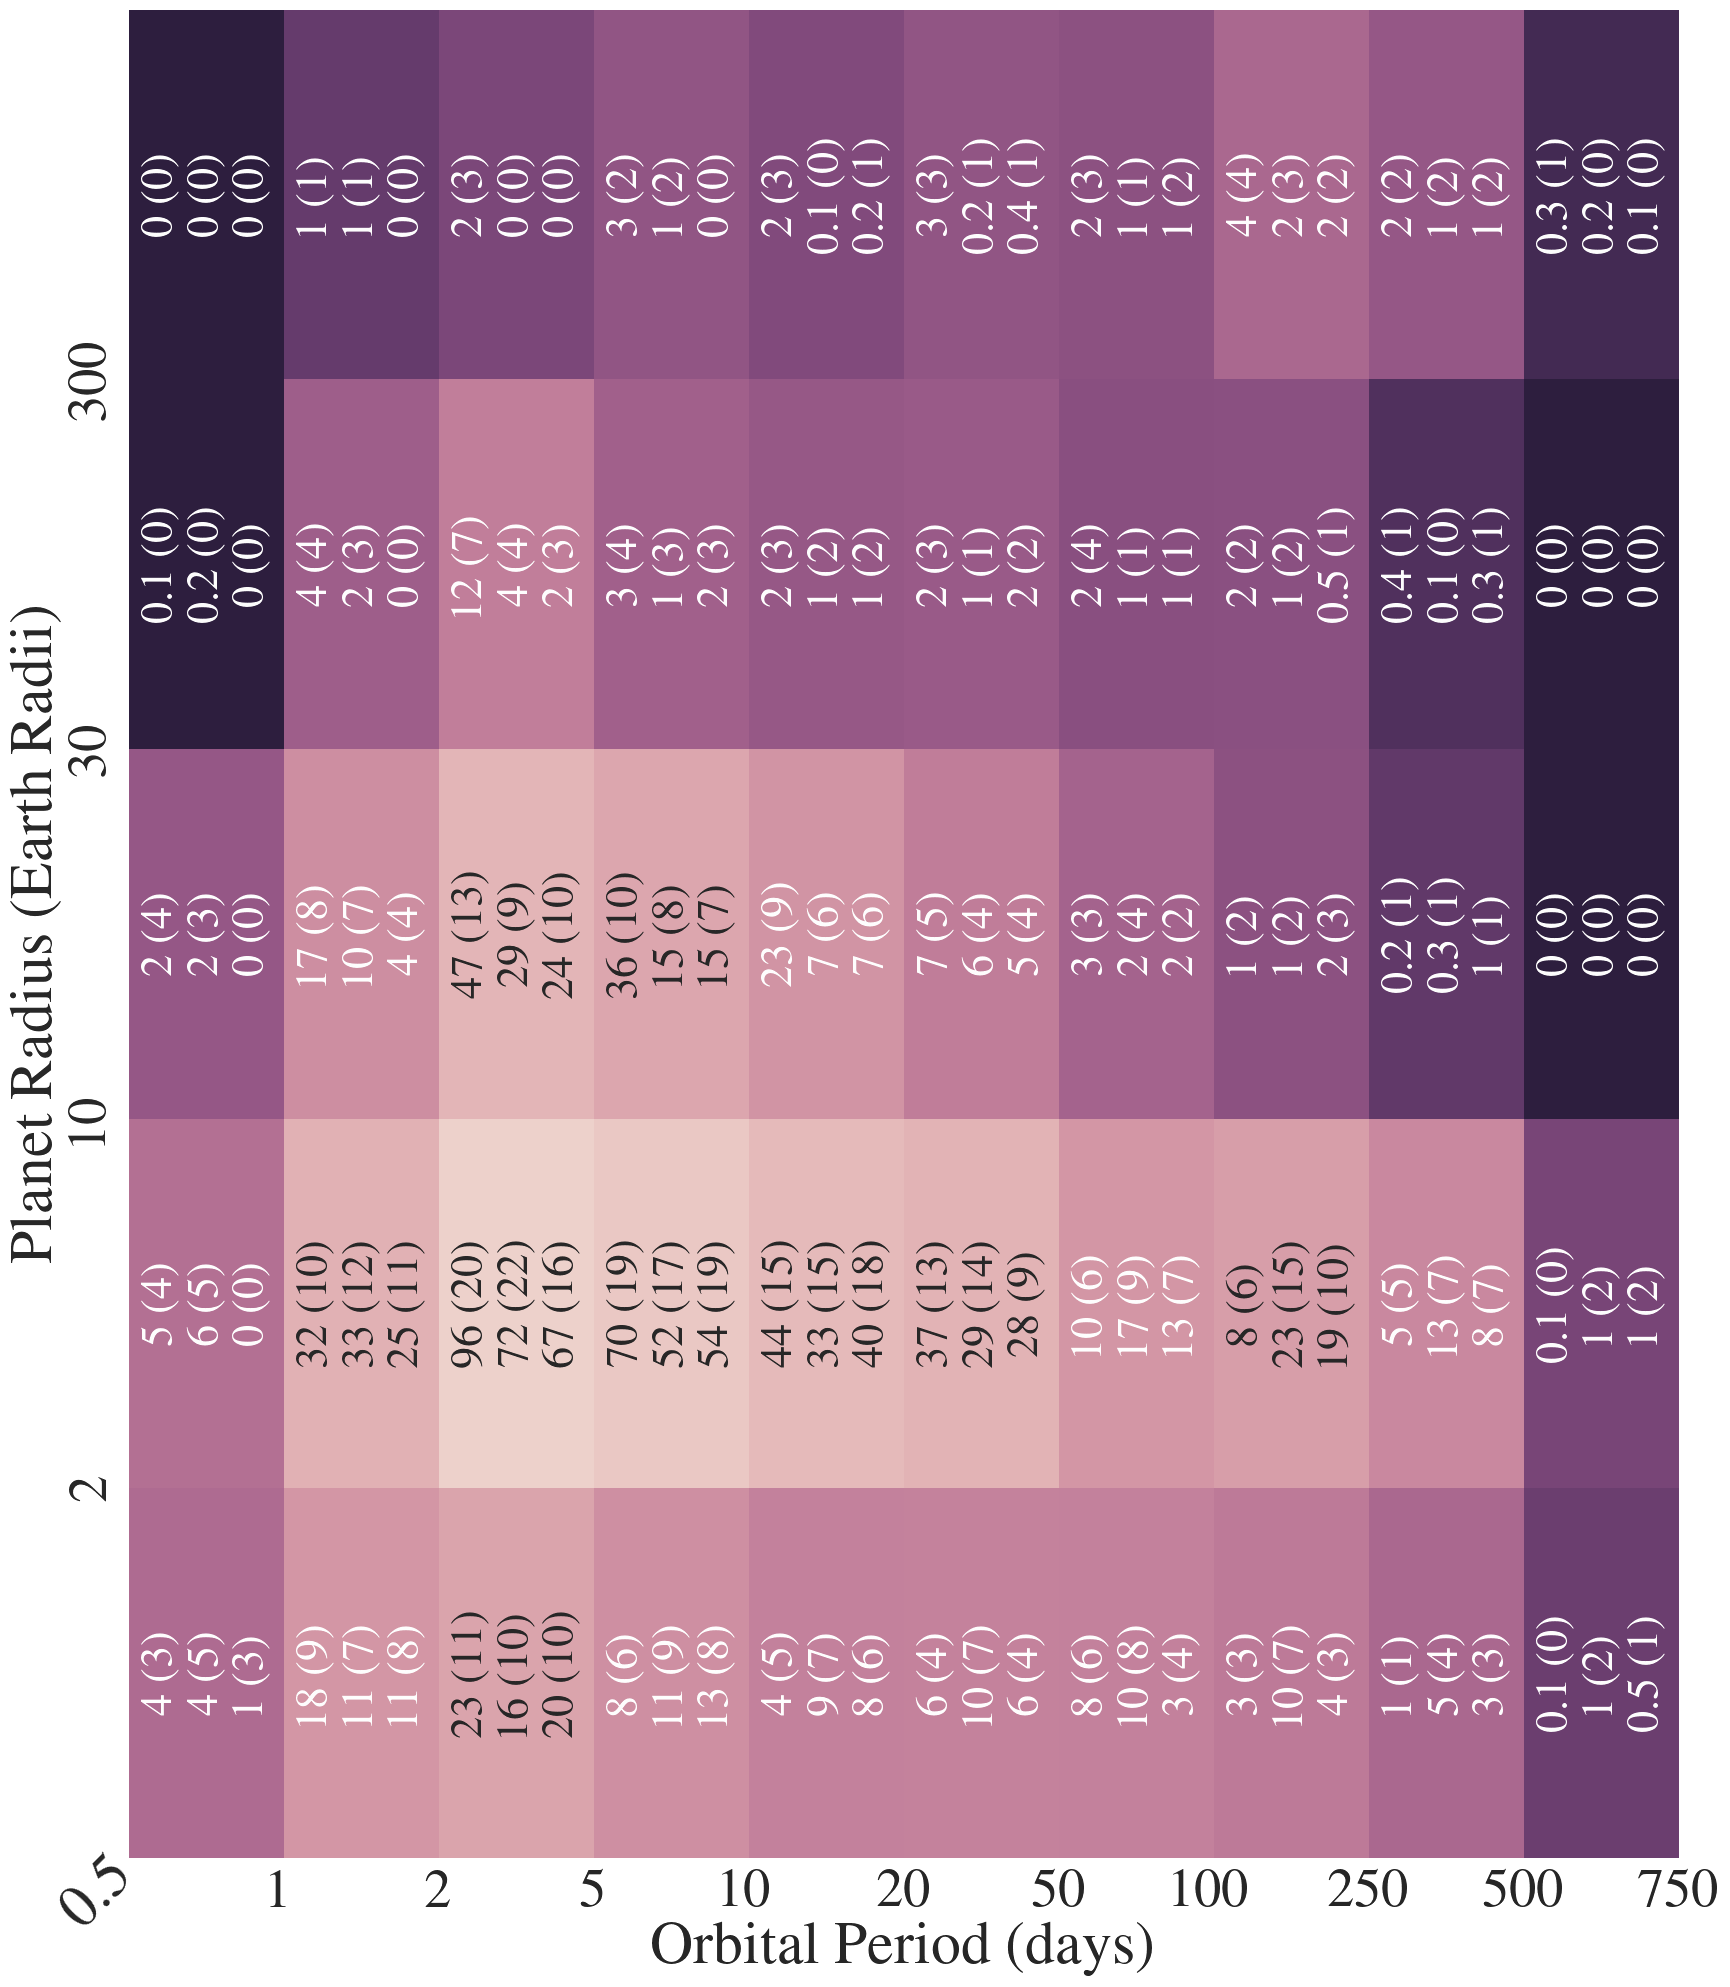

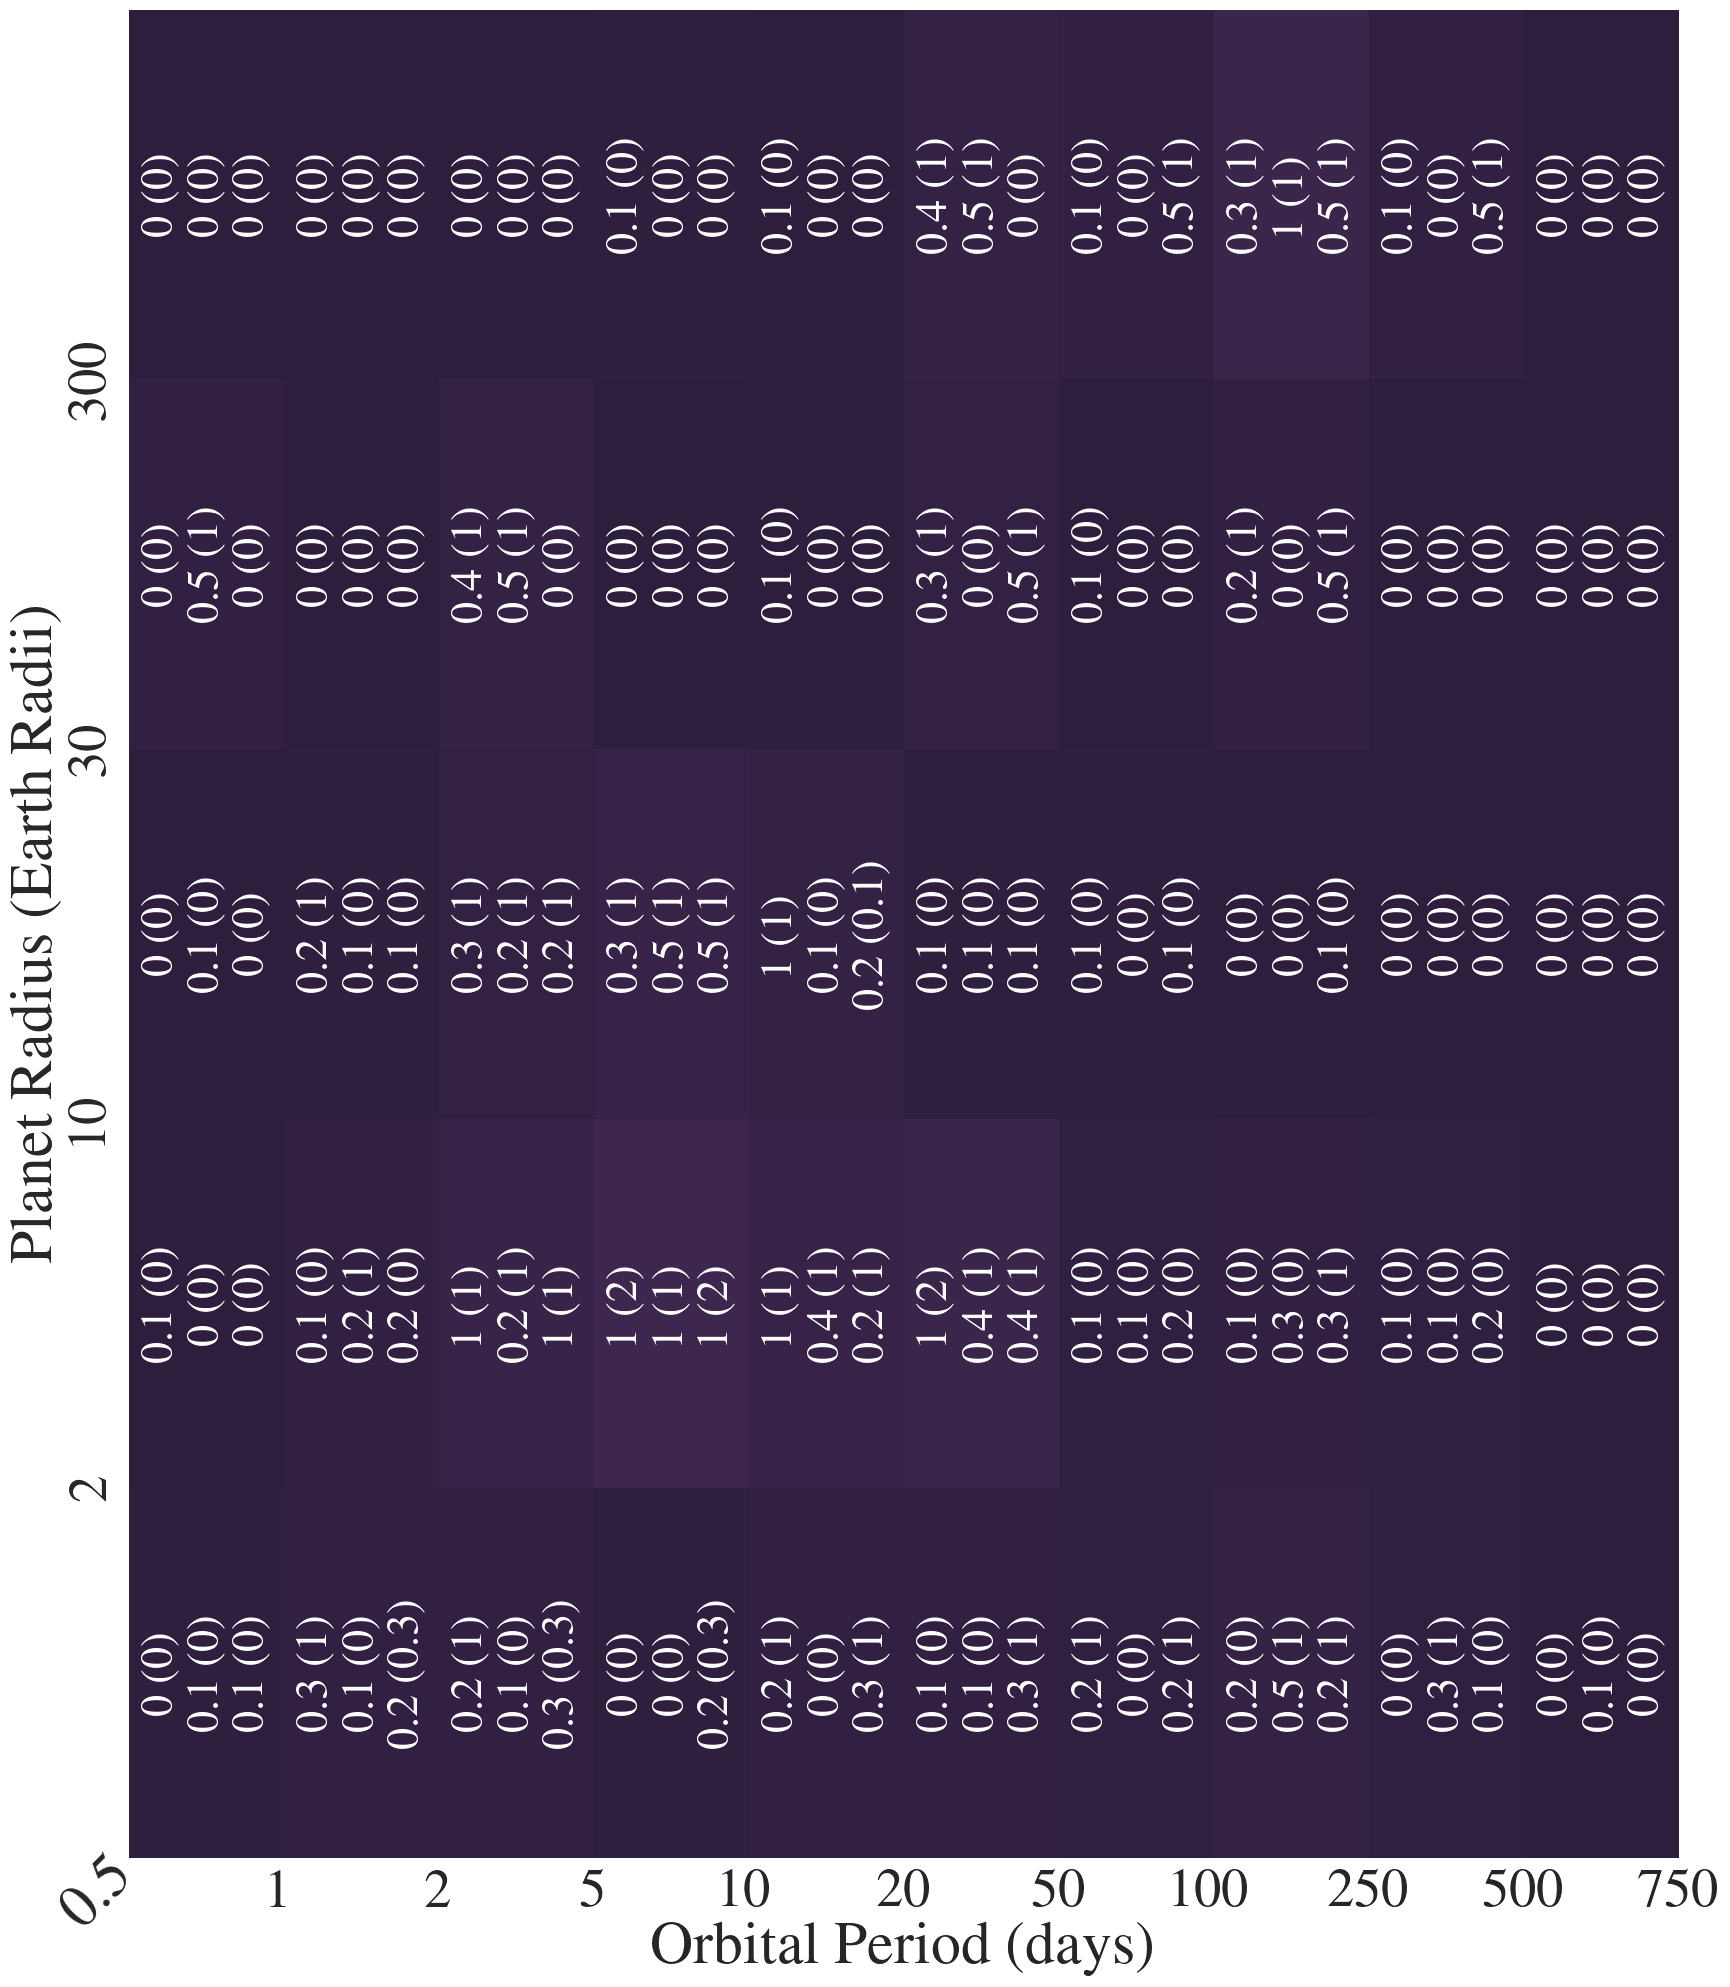

In [11]:
for pop_name, pop_val in pops.items():
    fig, ax = plt.subplots(figsize=(20, 24))
    heatmap = sns.heatmap(
        pop_val[0],
        annot=pop_val[1],
        cbar=False,
        cmap=get_palette(as_cmap=True, reverse=True),
        annot_kws={"fontsize": 32, "rotation": 90},
        norm=LogNorm(vmin=0.1, clip=True) if "Halo" not in pop_name else None,
        vmax=10 if "Halo" in pop_name else None,
        fmt="",
        # square=True,
        ax=ax,
    )

    heatmap.set_xlabel("Orbital Period (days)")
    heatmap.set_ylabel("Planet Radius (Earth Radii)")

    heatmap.set_xticks(
        ticks=np.arange(len(period_bins)),
        labels=[""] + [bin for bin in period_bins[1:]],
    )
    radius_bins = ["", "2", "10", "30", "300", ""]
    heatmap.set_yticks(
        np.arange(len(radius_bins)),
        labels=radius_bins[::-1],
    )
    fig.text(0.11, 0.095, "0.5", ha="center", va="center", rotation=45)

    figure_name_dict: dict = {
        "Thin Disk": "thin_disk",
        "Thick Disk": "thick_disk",
        "Halo": "halo",
        "Thin Disk (Metallicity Cut)": "thin_disk_metallicity_cut",
        "Thick Disk (Metallicity Cut)": "thick_disk_metallicity_cut",
        "Halo (Metallicity Cut)": "halo_metallicity_cut",
    }

    FigureProcessor(heatmap).save(
        f"observation_heatmap_{figure_name_dict[pop_name]}.pdf",
        figure_directory=figure_directory,
        save=save,
    )

In [9]:
# total number of expected planets
num_planets = {}
for num_embryos in [10, 20, 50, 100]:
    num_planets_per_pop = {}
    for pop in [
        "Thick Disk",
        "Thin Disk",
        "Halo",
        "Thin Disk (Metallicity Cut)",
        "Thick Disk (Metallicity Cut)",
        "Halo (Metallicity Cut)",
    ]:
        mocks = (
            obs_model.metallicity_cut_mocks[num_embryos]
            if "Metallicity Cut" in pop
            else obs_model.mocks[num_embryos]
        )

        num_planets_per_pop[pop] = np.median(
            [
                len(mock[mock["Population"] == pop.replace(" (Metallicity Cut)", "")])
                for mock in mocks
            ]
        )

    num_planets[num_embryos] = num_planets_per_pop

num_planets = pd.DataFrame.from_dict(num_planets).round(0).astype(int)

num_planets.index.name = "Population"
num_planets.columns.name = "Number of Embryos"
num_planets.loc["Total"] = num_planets.loc[
    [
        "Thin Disk",
        "Thick Disk",
        "Halo",
    ]
].sum(axis=0)
num_planets.loc["Total (Metallicity Cut)"] = num_planets.loc[
    [
        "Thin Disk (Metallicity Cut)",
        "Thick Disk (Metallicity Cut)",
        "Halo (Metallicity Cut)",
    ]
].sum(axis=0)

num_planets.loc["[Fe/H] < -0.6"] = (
    num_planets.loc["Total"] - num_planets.loc["Total (Metallicity Cut)"]
)

num_planets

Number of Embryos,10,20,50,100
Population,,,,
Thick Disk,778,1013,488,428
Thin Disk,14696,16483,14390,12321
Halo,43,77,4,5
Thin Disk (Metallicity Cut),13612,14749,14314,12242
Thick Disk (Metallicity Cut),568,617,456,398
Halo (Metallicity Cut),4,6,1,1
Total,15517,17573,14882,12754
Total (Metallicity Cut),14184,15372,14771,12641
[Fe/H] < -0.6,1333,2201,111,113


In [10]:
# print(num_planets.astype(str).to_latex())